# Implementation of FIR Filter in the FPGA

## Generation of the signal

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import lfilter, firwin #fundamental to simulate a fir_filter in python
import fileinput
from scipy.fft import fft, fftfreq
import sys

In [2]:
# To create the signal
def sine_wave(A, time, f): # creates a sine wave
    return A * np.sin(2 * np.pi * f * time) # F(t) = A sin(wt) = A sin(2pi f t)

t = [0.         0.00200401 0.00400802] ... [0.99599198 0.99799599 1.        ]


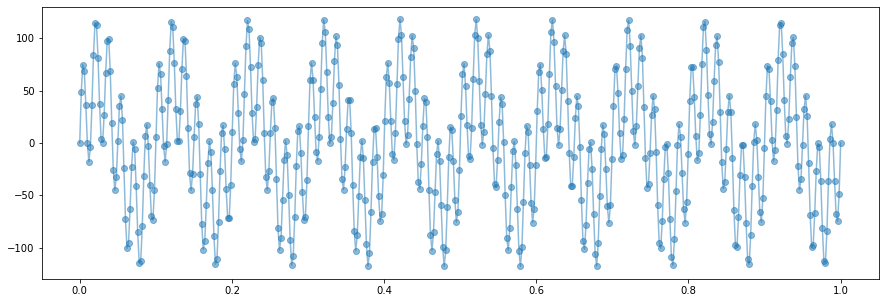

In [82]:
data_size = 500

# X-Axis
t = np.linspace(0, 1, data_size) 
print('t =',t[:3],'...',t[data_size-3:])

#Now we generate the wave
A1, A2 = 60, 60
f1, f2 = 10, 60

wave = sine_wave(A1, t, f1) + sine_wave(A2, t, f2)

# Let's plot it
plt.figure(figsize=(15, 5))

plt.plot(t, wave, '-o',alpha=.5,label='Raw signal')

In [4]:
file = open("../signal.txt", "w") # the file where to write the signal to be filtered

In [5]:
numtaps = 4 
f = 30

# this function gives us the coefficients used in the testbench
# numtaps = 4 depends on the structure of the filter (in the weighted sum we add 4 terms)
# f = the cutoff frequency (for a Low-pass from 0 to f)
# fs = The sampling frequency of the signal. 
#      Each frequency in cutoff must be between 0 and fs/2.  (Nyquist theorem)
#      fs is the number of samples obtain in one second
c = signal.firwin(numtaps, f, fs=data_size)
print("Coefficients for the Fir Filter:", c)

coeffpot = 8
rc = c * 2**coeffpot
print(rc)
trunc_rc = np.round(rc,0).astype(int)
bin_rc = []
hex_rc = []

for i in range(numtaps):
    bin_rc.append(bin(trunc_rc[i]))
    hex_rc.append(hex(trunc_rc[i]))
    
print(bin_rc)
print(hex_rc)

Coefficients for the Fir Filter: [0.01875932 0.48124068 0.48124068 0.01875932]
[  4.80238609 123.19761391 123.19761391   4.80238609]
['0b101', '0b1111011', '0b1111011', '0b101']
['0x5', '0x7b', '0x7b', '0x5']


In [6]:
c = signal.firwin(4, 3, fs=125)
rc = c * 2**8
hex_rc = []

for i in range(numtaps):
    hex_rc.append(hex(trunc_rc[i]))

print(rc)    
print(hex_rc)

[ 11.964436 116.035564 116.035564  11.964436]
['0x5', '0x7b', '0x7b', '0x5']


In [7]:
file = open("../signal.txt", "w") # the file where to write the signal to be filtered
np.savetxt(file, wave, fmt='%d', delimiter='\n')

file.close()

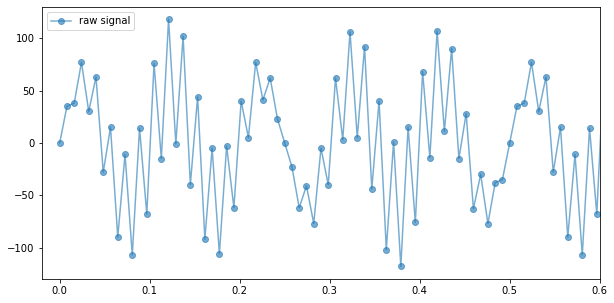

In [8]:
# Now we visualize it:
sig = np.loadtxt("../signal.txt", delimiter='\n')

plt.figure(figsize=(10, 5))
plt.xlim(-0.02,0.6)
plt.plot(t, sig, '-o',alpha=.6,label='raw signal')
plt.legend(loc="upper left")

## Results

In [9]:
# After being computed on the actual FPGA
##############
code = 'VElAx'
##############
url = 'https://transfer.sh/'+ code +'/output.txt'

! curl $url --output ../fromfpga.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   371  100   371    0     0    348      0  0:00:01  0:00:01 --:--:--   349


In [10]:
fname = "../fromfpga.txt"
fpga = np.loadtxt(fname, delimiter='\n')
for i in range(len(fpga)):
    # 2**10 due to truncation of bits
    # 2**9 because I multiplied the coefficients by 2**9
    fpga[i] = (2**10/2**8)*fpga[i]

In [11]:
# this function simulates the output of a fir_filter
python_sig = lfilter(c, 1, wave)

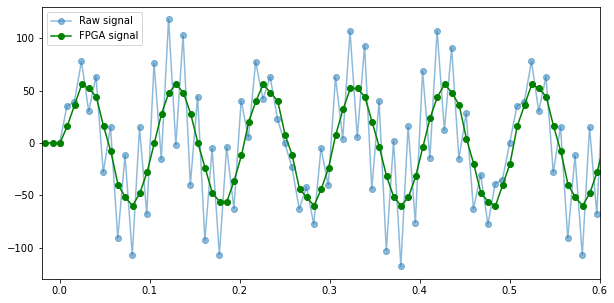

In [12]:
plt.figure(figsize=(10, 5))

plt.plot(t, wave, '-o',alpha=.5,label='Raw signal')
plt.plot(t-5/data_size, fpga, '-o', color='g',alpha=1,label='FPGA signal')
#plt.plot(t-5/data_size, fpga, '-o', color='r',alpha=1,label='Python simulated')
#plt.title("")
plt.xlim(-0.02,0.6)
plt.legend(loc="upper left")

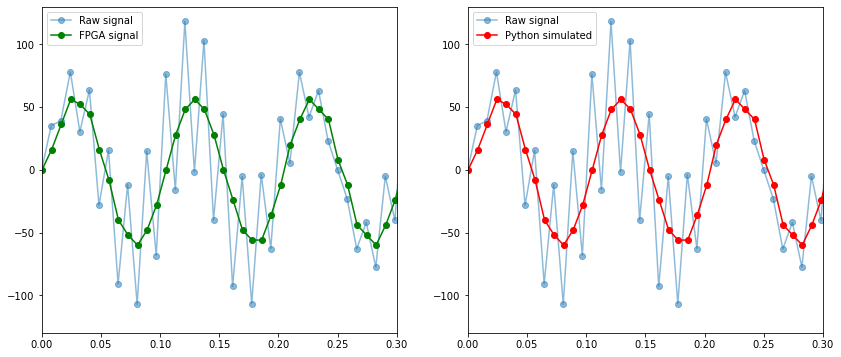

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

plt.xlim(0,.2)
ax1.plot(t, wave, '-o',alpha=.5,label='Raw signal')
ax1.plot(t-5/data_size, fpga, '-o', color='g',alpha=1,label='FPGA signal')
ax1.set_xlim(0,0.3)

ax1.legend(loc="upper left")

ax2.plot(t, wave, '-o',alpha=.5,label='Raw signal')
ax2.plot(t-5/data_size, fpga, '-o', color='r',alpha=1,label='Python simulated')
ax2.set_xlim(0,0.3)

ax2.legend(loc="upper left")

## Fourier Analysis

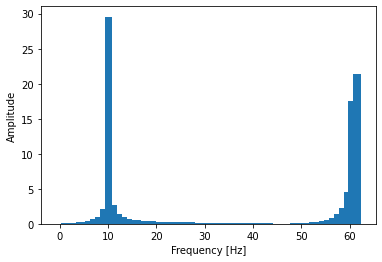

In [80]:
fft = np.fft.fft(wave)
T = 1 / data_size  # sampling interval 
N = data_size

# 1/T = frequency
f = np.linspace(0, 1 / T, N)

plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.bar(f[:N // 2], np.abs(fft)[:N // 2] * 1 / N, width=1.5)  # 1 / N is a normalization factor
plt.show()